# Test Notebook to visualize the data and start playing around

## Libraries

In [98]:
import pandas as pd
import numpy as np
import math
%matplotlib inline
from matplotlib import pyplot as plt
import random
random.seed(1)

## Import of Picture data

In [99]:
df = pd.read_csv(r'data\hmnist_28_28_L.csv')
print(df)

## Display of images

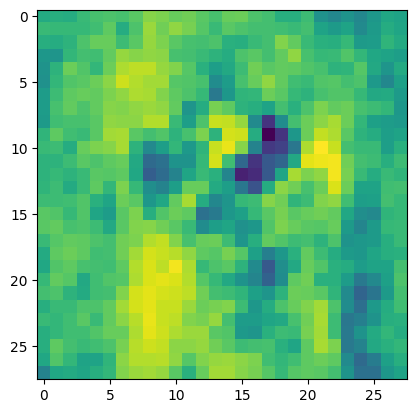

In [100]:
def disp_img(data_vec):
    if math.sqrt(np.size(data_vec)) != int(math.sqrt(np.size(data_vec))):
        img_label = data_vec[-1]
        img_vec = data_vec[0:-1]
    else:
        img_vec = data_vec

    size = np.size(img_vec)
    dimension = int(math.sqrt(size))

    img_mat = np.reshape(np.array(img_vec), (dimension, dimension))

    plt.imshow(img_mat)
    plt.show()

img_number = 0
data_vec = df.loc[img_number]

disp_img(data_vec)

# Extraction and grouping of labels 

In [101]:
label = df['label']
uniq_label, counts_label = np.unique(label, return_counts=True)
print(list(zip(uniq_label, counts_label)))

[(0, 327), (1, 514), (2, 1099), (3, 115), (4, 6705), (5, 142), (6, 1113)]


# Import of Metadata

In [102]:
df_meta = pd.read_csv(r'data\HAM10000_metadata.csv')
print(df_meta)

# Extraction of different diagnostic cathegories

Labels / Cathegories:

0 / Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec)

1 / basal cell carcinoma (bcc)

2 / benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl)

3 / dermatofibroma (df)

4 / melanoma (mel)

5 / melanocytic nevi (nv)

6 / vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc)

In [103]:
cath = df_meta['dx']
uniq_cath, counts_cath = np.unique(cath, return_counts=True)
print(list(zip(uniq_cath, counts_cath)))

[('akiec', 327), ('bcc', 514), ('bkl', 1099), ('df', 115), ('mel', 1113), ('nv', 6705), ('vasc', 142)]


# Grouping the pictures by the different diagnosis

In [104]:
img_index_group = []                #List with 6 nested lists; index of nested list = label / cathegorie; values in nested lists = index of pictures belonging to that label /cathegorie
for i in range(len(uniq_label)):
    img_index_group.append([])
    for j in range(df.shape[0]):
        if df['label'][j] == i:
            img_index_group[i].append(j)

print(list((i, len(img_index_group[i])) for i in range(len(img_index_group))))
#print(img_index_group)

[(0, 327), (1, 514), (2, 1099), (3, 115), (4, 6705), (5, 142), (6, 1113)]


# Splitting into training and testing data

In [105]:
training_split = 0.9                #Percentage of Data used for training
img_index_group_split = []          #Same as img_index_group but every nested list is split into two lists: first is list for training, second is list for testing

for i in range(len(img_index_group)):
    random.shuffle(img_index_group[i])
    split_point = round(len(img_index_group[i])*training_split)
    img_index_group_split.append([img_index_group[i][:split_point], img_index_group[i][split_point:]])
    
    #print(i)
    #print(len(img_index_group_split[i][0]))
    #print(len(img_index_group_split[i][1]))

#print(img_index_group_split)

# Running Clustering on the different diagnosis

## Principal Component Analysis

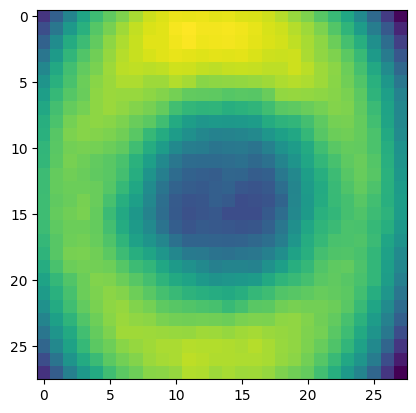

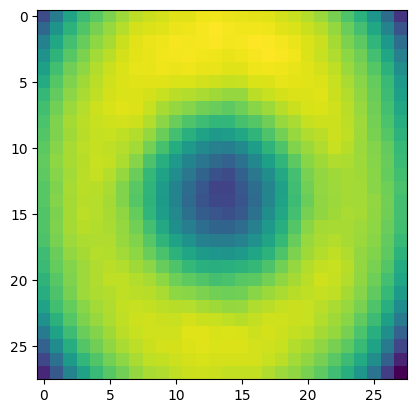

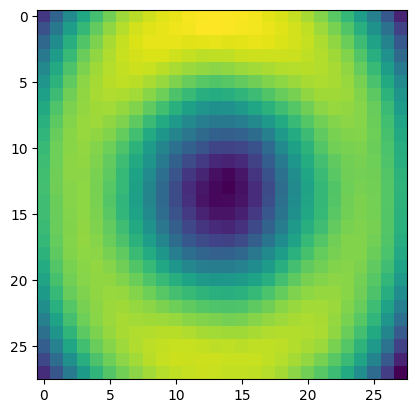

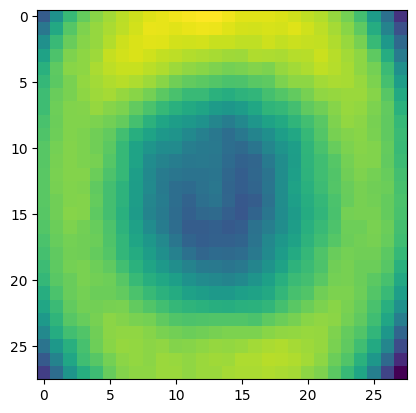

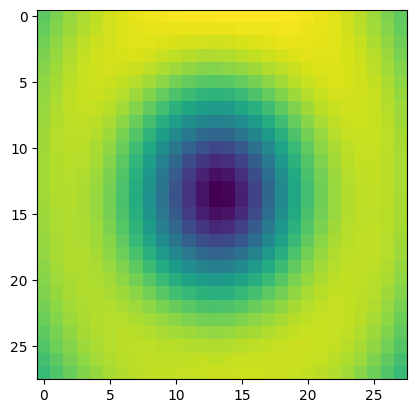

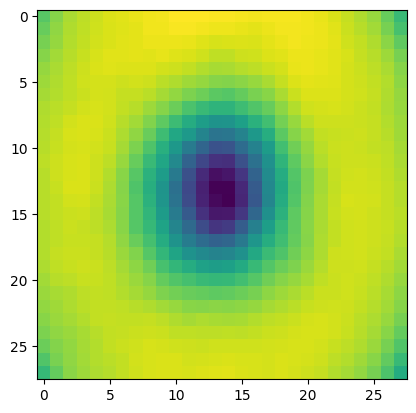

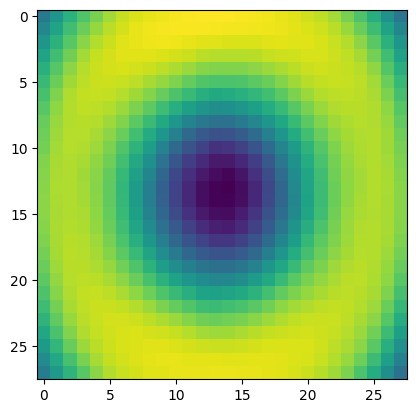

In [106]:
mean = []

for i in range(len(img_index_group)):
    mean.append(np.mean(df.loc[img_index_group[i]], axis=0))
    
    disp_img(mean[i])
    #print(mean[i])


In [107]:
df_sub_mean = pd.DataFrame()
for i in range(len(img_index_group)):
    df_sub_mean = pd.concat((df_sub_mean, df.loc[img_index_group[i]]-mean[i]))

df_sub_mean.sort_index(axis=0, inplace=True)

#print(df_sub_mean)

In [108]:
df_matrix = df_sub_mean.iloc[:, :-1]

eig_vec = []
eig_val = []

for i in range(len(img_index_group)):
    matrix = df_sub_mean.loc[img_index_group[i]]
    val, vec = np.linalg.eig(matrix.transpose().dot(matrix))
    eig_val.append(val)
    eig_vec.append(vec)

#print(eig_val)
#print(eig_vec)
